# Baseline Models - Debugging


---


**Mentor:**
  - ***Professor Richard Sowers***, Department of Industrial and Systems Engineering, University of Illinois at Urbana-Champaign (UIUC).

**Group Members:**
  - ***Advika Pattiwar*** (linkedin.com/in/advika-pattiwar)
  - ***Dhruv Borda*** (linkedin.com/thebordadhruv)
  - ***Hrithik Rathi*** (linkedin.com/in/hrithik-rathi)
  - ***Suvrata Gayathri Kappagantula*** (linkedin.com/in/gayathrikappagantula)


---



## 1. Predicting Destination Station

- **Model Type**: Classification model predicting the end station based on the ride's starting conditions.
- **Features**:
  - `Start station`: Frequency encoded.
  - `Rideable type`: One-hot encoded.
  - `User type`: One-hot encoded.
  - Start time: Cyclical encoding for `hour` and `weekday`.
  - Geographical coordinates: Normalized starting `latitude` and `longitude`.
  - Weather binary indicators: `WT01`, `WT02`, `WT03`, `WT08`.
  - Weather continuous variables: `AWND`, `PRCP`, `SNOW`, `SNWD`, `TMAX`, `TMIN`, `WDF2`, `WDF5`, `WSF2`, `WSF5` (all normalized).
- **Target Variable**: `End station name` (label encoded).
- **Model**: Random Forest Classifier.
- **Performance Metric**: Accuracy.


## 2. Predicting Bike Station Popularity Based on Previous Day Data

- **Model Type**: Regression model to predict the number of bikes that will be dropped off to a station in a given day, based on the day, day of the week, week of the year, month of the year, weather and the number of bikes that were dropped off to that station on the previous day.

- **Features**:
  - `day`: Day(with cyclical encoding as `day_sin` and `day_cos`).
  - `weekday`: Day of the week (with cyclical encoding as `weekday_sin` and `weekday_cos`).
  - `week`: Week of the year (with cyclical encoding as `week_sin` and `week_cos`).
  - `month`: Month of the year (with cyclical encoding as `month_sin` and `month_cos`).
  - Weather binary indicators: `WT01`, `WT02`, `WT03`, `WT08`.
  - Weather continuous variables: `TMAX`, `TMIN`, `WDF2`, `WDF5`, `WSF2`, `WSF5`, `AWND`, `PRCP`, `SNOW`, `SNWD` (all normalized).
  - `lagged`: Number of bikes dropped off from the station on the previous day.

- **Target Variable**: The number of bikes dropped off (`number_of_dropoffs`).
- **Model**: Linear Regression, XGBoost
- **Performance Metrics**: Mean Absolute Error (MAE), R-squared.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install boto3

In [ ]:
import io
from io import StringIO
import requests

import boto3
from botocore import UNSIGNED
from botocore.client import Config

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer

## 1. Predicting Destination Station


### Access data from AWS s3 bucket

In [ ]:
# Load the data from the URL
url = 'https://s3-us-east-2.amazonaws.com/dhruvborda-project-nyccitibikerentals/Dataset/debugging.pkl'
response = requests.get(url)

if response.status_code == 200:
    debugging = pd.read_pickle(io.BytesIO(response.content))
    print('Data loaded successfully.')
else:
    print(f'Failed to download debugging.pkl. Status code: {response.status_code}')
    exit()  # Exit if data loading fails

Data loaded successfully.


### Feature Engineering and Data Preparation

In [ ]:
# Label Encoding for 'end_station_name'
label_encoder = LabelEncoder()
debugging['end_station_name_encoded'] = label_encoder.fit_transform(debugging['end_station_name'])

# Frequency encoding for 'start_station_name'
frequency_encoding = debugging['start_station_name'].value_counts().to_dict()
debugging['start_station_name_encoded'] = debugging['start_station_name'].map(frequency_encoding)

# One-Hot Encoding for 'rideable_type' and 'member_casual'
one_hot_encoder = OneHotEncoder()
categorical_encoded = one_hot_encoder.fit_transform(debugging[['rideable_type', 'member_casual']]).toarray()

# WT01, WT02, WT03, and WT08 are binary weather indicators
weather_binary_columns = ['WT01', 'WT02', 'WT03', 'WT08']
binary_encoded = debugging[weather_binary_columns].to_numpy()

# Normalize continuous variables
continuous_columns = ['start_lat', 'start_lng', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5']
scaler = StandardScaler()
continuous_normalized = scaler.fit_transform(debugging[continuous_columns])

# Cyclical Encoding for 'hour' and 'weekday'
def encode_cyclical_feature(value, max_value):
    value_scaled = value / max_value
    return np.sin(value_scaled * 2 * np.pi), np.cos(value_scaled * 2 * np.pi)

hour_encoded = np.array(debugging['hour'].apply(encode_cyclical_feature, max_value=23).tolist())
weekday_encoded = np.array(debugging['weekday'].apply(encode_cyclical_feature, max_value=6).tolist())

In [ ]:
# Combine all features
X = np.concatenate((debugging[['start_station_name_encoded']].values,
                    categorical_encoded,
                    binary_encoded,
                    continuous_normalized,
                    hour_encoded,
                    weekday_encoded), axis=1)
y = debugging['end_station_name_encoded']

# Split the dataset into the Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Baseline Model


In [ ]:
# Use a Random Forest Classifier as the baseline model
classifier = RandomForestClassifier(n_estimators=100, random_state=1)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Evaluating the Model Performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100} %')

Accuracy: 1.0526315789473684 %


## 2. Predicting Bike Station Popularity Based on Previous Day Data

### Access data from AWS s3 bucket

In [ ]:
# Load the data from the URL
url = 'https://s3-us-east-2.amazonaws.com/dhruvborda-project-nyccitibikerentals/Dataset/debugging.pkl'
response = requests.get(url)

if response.status_code == 200:
    debugging = pd.read_pickle(io.BytesIO(response.content))
    print('Data loaded successfully.')
else:
    print(f'Failed to download debugging.pkl. Status code: {response.status_code}')
    exit()  # Exit if data loading fails

# AWS S3 bucket details
BUCKET_NAME = 'dhruvborda-project-nyccitibikerentals'
FILE_KEY = 'Dataset/Weather_DailySummaries.csv'

# Initialize S3 client
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
obj = s3.get_object(Bucket=BUCKET_NAME, Key=FILE_KEY)
DailyWeather = pd.read_csv(StringIO(obj['Body'].read().decode('utf-8')))

# Data Preparation for Weather Data
DailyWeather.drop(['NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'PGTM', 'TAVG'], axis=1, inplace=True)
DailyWeather['DATE'] = pd.to_datetime(DailyWeather['DATE'])
DailyWeather.fillna(0, inplace=True)

Data loaded successfully.


### Feature Engineering and Data Preparation

In [ ]:
# Aggregate Data for Daily Drop-off Counts
daily_dropoffs = debugging.groupby(['end_station_name', 'date'])['ride_id'].count().reset_index()
daily_dropoffs.rename(columns={'ride_id': 'number_of_dropoffs'}, inplace=True)

# Extract Date features
daily_dropoffs['year'] = daily_dropoffs['date'].dt.year
daily_dropoffs['month'] = daily_dropoffs['date'].dt.month
daily_dropoffs['week'] = daily_dropoffs['date'].dt.isocalendar().week
daily_dropoffs['day'] = daily_dropoffs['date'].dt.day
daily_dropoffs['weekday'] = daily_dropoffs['date'].dt.weekday

# Merge with Daily Weather Data
daily_dropoffs = pd.merge(daily_dropoffs, DailyWeather, left_on='date', right_on='DATE', how='left')
daily_dropoffs.drop(['DATE', 'STATION'], axis=1, inplace=True)

# Sort by 'date' and calculate the difference in days
daily_dropoffs = daily_dropoffs.sort_values(by=['date'])
daily_dropoffs['date_difference'] = daily_dropoffs.groupby('end_station_name')['date'].diff().dt.days

# Determine Lagged Data
lagged_data = daily_dropoffs[daily_dropoffs['date_difference'] == 1].copy()
lagged_data['lagged'] = lagged_data.sort_values(by=['date'], ascending=True).groupby(['end_station_name'])['number_of_dropoffs'].shift(1)

# Determine Non-Lagged Data
non_lagged_data = daily_dropoffs[daily_dropoffs['date_difference'] != 1].copy()
non_lagged_data['lagged'] = 0

# Combine Lagged and Non-Lagged Data
combined_data = pd.concat([lagged_data, non_lagged_data])
combined_data['lagged'].fillna(0, inplace=True)

# Final Data Preparation
final_data = combined_data.sort_values(['end_station_name', 'date'])

# Aggregating Final Data
aggregated_final_data = final_data.groupby(['end_station_name', 'date']).agg({
    'lagged':'mean',
    'number_of_dropoffs':'mean',
    'AWND':'mean', 'PRCP':'mean', 'SNOW':'mean', 'SNWD':'mean', 'TMAX':'mean', 'TMIN':'mean',
    'WDF2':'mean', 'WDF5':'mean', 'WSF2':'mean', 'WSF5':'mean', 'WT01':'max', 'WT02':'max',
    'WT03':'max', 'WT08':'max'
}).reset_index()

# Extract Date features
aggregated_final_data['year'] = aggregated_final_data['date'].dt.year
aggregated_final_data['month'] = aggregated_final_data['date'].dt.month
aggregated_final_data['week'] = aggregated_final_data['date'].dt.isocalendar().week
aggregated_final_data['day'] = aggregated_final_data['date'].dt.day
aggregated_final_data['weekday'] = aggregated_final_data['date'].dt.weekday

# Binary Encoding for Weather Indicators
weather_binary_columns = ['WT01', 'WT02', 'WT03', 'WT08']
binary_encoded = aggregated_final_data[weather_binary_columns].to_numpy()

# Normalize Continuous Variables (including additional weather variables)
continuous_columns = ['TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'AWND', 'PRCP', 'SNOW', 'SNWD']
scaler = StandardScaler()
continuous_normalized = scaler.fit_transform(aggregated_final_data[continuous_columns])

# Cyclical Encoding for 'day', 'weekday', 'week', and 'month'
def encode_cyclical_feature(value, max_value):
    value_scaled = value / max_value
    return np.sin(value_scaled * 2 * np.pi), np.cos(value_scaled * 2 * np.pi)

day_encoded = np.array(aggregated_final_data['day'].apply(lambda x: encode_cyclical_feature(x, 31)).tolist())
weekday_encoded = np.array(aggregated_final_data['weekday'].apply(lambda x: encode_cyclical_feature(x, 6)).tolist())
week_encoded = np.array(aggregated_final_data['week'].apply(lambda x: encode_cyclical_feature(x, 52)).tolist())
month_encoded = np.array(aggregated_final_data['month'].apply(lambda x: encode_cyclical_feature(x, 12)).tolist())

In [ ]:
# Combine all features
X = np.concatenate((aggregated_final_data[['lagged']].values,
                    binary_encoded,
                    continuous_normalized,
                    day_encoded,
                    weekday_encoded,
                    week_encoded,
                    month_encoded), axis=1)

y = aggregated_final_data['number_of_dropoffs'].values

# Split the dataset into the Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Baseline Models


Mean Squared Error: 0.28132920485179425
Mean Absolute Error: 0.3575540630841465
R-squared: 0.006540513431751993


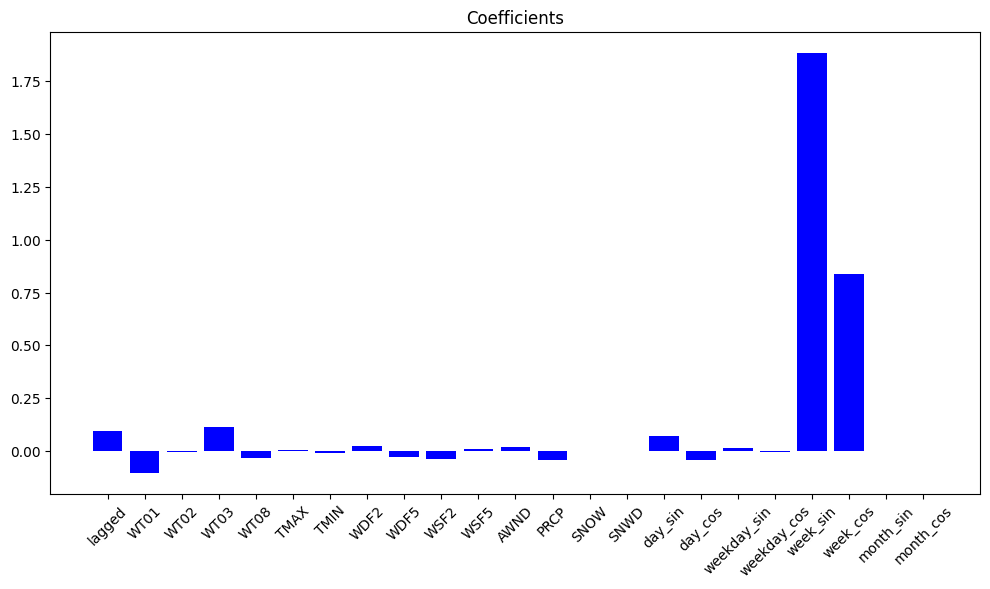

In [ ]:
# Fitting Simple Linear Regression to the Training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)

# Evaluating the Model Performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

# Getting the coefficients
coefficients = regressor.coef_

# Feature names
feature_names = ['lagged', 'WT01', 'WT02', 'WT03', 'WT08', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'AWND', 'PRCP', 'SNOW', 'SNWD'] + \
                ['day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos']

# Plotting
plt.figure(figsize=(12, 6))
plt.title('Coefficients')
plt.bar(range(len(coefficients)), coefficients, color='b', align='center')
plt.xticks(range(len(coefficients)), feature_names, rotation=45)

# Save the figure to Google Drive
plt.savefig('/content/drive/My Drive/Projects/Academic Projects/IE434_DeepLearning_Project/Visualizations/Baseline Model Debugging/Linear Regressor Coefficients.png')

XGBoost - Mean Squared Error: 0.2797429965230294
XGBoost - Mean Absolute Error: 0.3575540630841465
XGBoost - R-squared: 0.01214190029350748


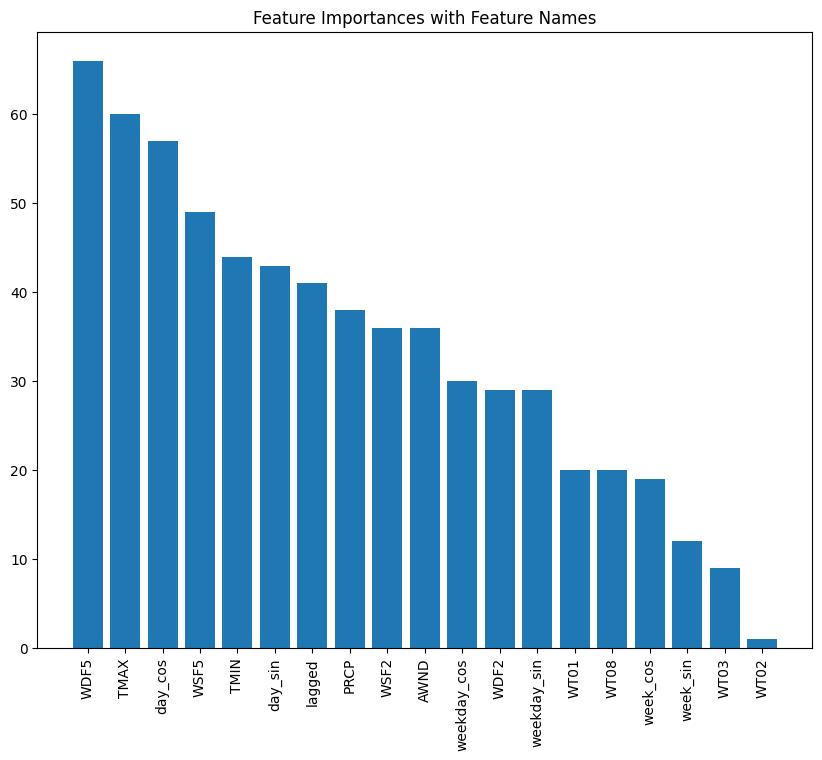

In [ ]:
# Initialize the
xgb_regressor = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100, random_state=1)

# Fit the regressor to the training data
xgb_regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred_xgb = xgb_regressor.predict(X_test)

# Evaluating the Model Performance
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - Mean Squared Error: {mse_xgb}')
print(f'XGBoost - Mean Absolute Error: {mae_xgb}')
print(f'XGBoost - R-squared: {r2_xgb}')


feature_names = ['lagged', 'WT01', 'WT02', 'WT03', 'WT08', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'AWND', 'PRCP', 'SNOW', 'SNWD'] + \
                ['day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos']

# Map the feature importance scores from the XGBoost model to the corresponding feature names
fmap = {f'f{i}': name for i, name in enumerate(feature_names)}
mapped_importance = {fmap[k]: v for k, v in xgb_regressor.get_booster().get_fscore().items()}

# Sort the feature importance dictionary by values
sorted_importance = {k: v for k, v in sorted(mapped_importance.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_importance)), list(sorted_importance.values()), align='center')
plt.xticks(range(len(sorted_importance)), list(sorted_importance.keys()), rotation=90)
plt.title('Feature Importances with Feature Names')

# Save the figure to Google Drive
plt.savefig('/content/drive/My Drive/Projects/Academic Projects/IE434_DeepLearning_Project/Visualizations/Baseline Model Debugging/XGBoost Feature Importance.png')